In [1]:
from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from fbprophet import Prophet

%matplotlib inline
plt.rcParams['figure.figsize']= (8,8)

from warnings import filterwarnings
filterwarnings('ignore')

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


## Load Data

In [2]:
train_features = pd.read_csv('./data/dengue_features_train.csv', index_col=[0,1,2])
train_labels = pd.read_csv('./data/dengue_labels_train.csv', index_col=[0,1,2])


## Preprocess Data
Preprocess data into features required for training.

In [3]:
def preprocess_data(train_features, train_labels=None):
    df = train_features.copy()
    
    celsius_list = ['station_max_temp_c', 'station_min_temp_c', 'station_avg_temp_c' ]
    for col in celsius_list:
        df[col] = df[col] + 273.15
    df = df.rename(columns = { name : name[:-2] + '_k' for name in celsius_list })
    
    df['station_max_temp_k'] = df.apply(lambda row : row.reanalysis_max_air_temp_k if np.isnan(row.station_max_temp_k) else row.station_max_temp_k, axis=1)
    df['station_min_temp_k'] = df.apply(lambda row : row.reanalysis_min_air_temp_k if np.isnan(row.station_min_temp_k) else row.station_min_temp_k, axis=1)
    df['station_avg_temp_k'] = df.apply(lambda row : row.reanalysis_avg_temp_k if np.isnan(row.station_avg_temp_k) else row.station_avg_temp_k, axis=1)
    df['station_precip_mm'] = df.apply(lambda row : row.reanalysis_sat_precip_amt_mm if np.isnan(row.station_precip_mm) else row.station_precip_mm, axis=1)
    
    features = ['station_max_temp_k', 
                 'station_min_temp_k', 
                 'station_avg_temp_k', 
                 'precipitation_amt_mm', 
                 'reanalysis_dew_point_temp_k', 
                 'reanalysis_air_temp_k', 
                 'reanalysis_relative_humidity_percent',
                 'reanalysis_precip_amt_kg_per_m2', 
                 'ndvi_se', 
                 'ndvi_ne', 
                 'station_precip_mm', 
                 'week_start_date']
    df.loc[df.station_max_temp_k]
    
    
    df = df[features]
    df.fillna(method='ffill', inplace=True)

    
    if train_labels is not None:
        labels = train_labels
        df = df.join(labels)
    
    sj = df.loc['sj']
    iq = df.loc['iq']
    
    return sj, iq

## Utility Functions

In [4]:
def plot_against(sj_pred, iq_pred):
    figs, axes = plt.subplots(nrows=2, ncols=1)

    # plot sj
    sj_pred.plot(ax=axes[0], label="Predictions")
    sj_train.total_cases.plot(ax=axes[0], label="Actual")

    # plot iq
    iq_pred.plot(ax=axes[1], label="Predictions")
    iq_train.total_cases.plot(ax=axes[1], label="Actual")

    plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
    plt.legend()

In [5]:
def mae_calc(test, predicted):
    return (np.abs(test - predicted).sum())/len(test)

In [6]:
def save_benchmark(sj_predictions, iq_predictions):
    submission = pd.read_csv('./data/submission_format.csv', index_col=[0,1,2])
    submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
    submission.to_csv("benchmark.csv")

## Split Data
Split into Training and Testing data

In [7]:
sj_train, iq_train = preprocess_data(train_features, train_labels)

sj_train_subtrain = sj_train.head(800)
sj_train_subtest = sj_train.tail(sj_train.shape[0] - 800)

iq_train_subtrain = iq_train.head(400)
iq_train_subtest = iq_train.tail(iq_train.shape[0] - 400)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


## Statsmodel GLM Model
GLM models with different features for San Juan and Iquitos

In [8]:
def sj_glm_model(train, test):
    train = train.drop(columns=['week_start_date']).copy()
    test = test.drop(columns=['week_start_date']).copy()
    
    model_formula = "total_cases ~ 1 + " \
                    "reanalysis_relative_humidity_percent + reanalysis_dew_point_temp_k + " \
                    "station_min_temp_k + station_avg_temp_k"
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
    best_alpha = []
    best_score = 1000
    
    for alpha in grid:
        model = smf.glm(formula=model_formula, data=train, family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
    
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula, data=full_dataset, family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model

In [9]:
def iq_glm_model(train, test):
    train = train.drop(columns=['week_start_date']).copy()
    test = test.drop(columns=['week_start_date']).copy()
    
    model_formula = "total_cases ~ 1 + " \
                    "station_min_temp_k + station_avg_temp_k + station_max_temp_k + " \
                    "precipitation_amt_mm + reanalysis_dew_point_temp_k + reanalysis_air_temp_k + " \
                    "reanalysis_relative_humidity_percent + reanalysis_precip_amt_kg_per_m2 + " \
                    "ndvi_se + ndvi_ne + station_precip_mm"
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)             
    best_alpha = []
    best_score = 1000
    
    for alpha in grid:
        model = smf.glm(formula=model_formula, data=train, family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
    
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula, data=full_dataset, family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model    

In [10]:
def random_forest_model(train, test):
    train = train.drop(columns=['week_start_date']).copy()
    test = test.drop(columns=['week_start_date']).copy()
    
    X = train.drop(columns=['total_cases'])
    Y = train.total_cases
    
    reg = RandomForestRegressor(random_state=67)
    param_grid = [{
      'n_estimators': range(1, 16),
      'max_depth': range(1, 11)
    }]
    grid = GridSearchCV(reg, param_grid=param_grid, scoring='neg_mean_absolute_error')
    grid.fit(X, Y)
    
    print("Best score: {}".format(np.abs(grid.best_score_)))
    print("Best params: {}".format(grid.best_params_))
    
    full_dataset = pd.concat([train, test])
    reg = RandomForestRegressor(random_state=67, max_depth=grid.best_params_['max_depth'], n_estimators=grid.best_params_['n_estimators'])
    reg.fit(X, Y)
    
    return reg

In [11]:
def kneighbours_model(train, test):
    train = train.drop(columns=['week_start_date']).copy()
    test = test.drop(columns=['week_start_date']).copy()
    
    X = train.drop(columns=['total_cases'])
    Y = train.total_cases
    
    k_neighbours = range(1, 26)
    
    reg = KNeighborsRegressor()
    param_grid = [{"n_neighbors": k_neighbours}]
    grid = GridSearchCV(reg, param_grid=param_grid, scoring='neg_mean_absolute_error')
    grid.fit(X, Y)
    
    print("Best score: {}".format(np.abs(grid.best_score_)))
    print("Best params: {}".format(grid.best_params_))
    
    full_dataset = pd.concat([train, test])
    reg = KNeighborsRegressor(n_neighbors=grid.best_params_['n_neighbors'])
    reg.fit(X, Y)
    
    return reg

In [12]:
def fb_prophet_model(train, test, seas, flex):
    prophet_data = train[['week_start_date', 'total_cases']]
    prophet_data.columns = ['ds', 'y']
    prophet = Prophet(changepoint_prior_scale=flex, yearly_seasonality=seas) 
    prophet.fit(prophet_data)
    
    test_data = test["week_start_date"].copy()
    future_frame = prophet.make_future_dataframe(periods=len(test_data), freq='W')
    
    return prophet, future_frame

## Check Results
Checks results of models by plotting against actual values and calculating the Mean Absolute Error for the individual models and together.

In [13]:
models = ["GLM", "RFR", "KNN", "PRP"]
sj_models_mae = []
iq_models_mae = []

best alpha =  1e-08
best score =  21.698529411764707
best alpha =  1e-08
best score =  7.083333333333333
San Juan MAE: 27.447285546579646
Iquitos MAE: 6.348604803381742
Total MAE: 19.912042424008966


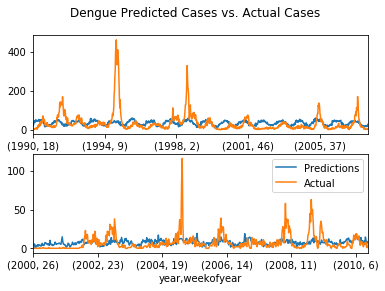

In [14]:
sj_best_model = sj_glm_model(sj_train_subtrain, sj_train_subtest)
iq_best_model = iq_glm_model(iq_train_subtrain, iq_train_subtest)
pred_sj = sj_best_model.fittedvalues
pred_iq = iq_best_model.fittedvalues

plot_against(pred_sj, pred_iq)

sj_mae = mae_calc(pred_sj, sj_train.total_cases)
sj_models_mae.append(sj_mae)
print("San Juan MAE:", sj_mae)
iq_mae = mae_calc(pred_iq, iq_train.total_cases)
iq_models_mae.append(iq_mae)
print("Iquitos MAE:", iq_mae)
total_mae = (np.abs(pred_sj - sj_train.total_cases).sum() + 
             np.abs(pred_iq - iq_train.total_cases).sum()) / (sj_train.shape[0] + iq_train.shape[0])
print("Total MAE:", total_mae)

Best score: 29.99013687160937
Best params: {'max_depth': 2, 'n_estimators': 12}
Best score: 6.661303413561204
Best params: {'max_depth': 2, 'n_estimators': 3}
San Juan MAE: 23.426819000971275
Iquitos MAE: 5.903458539823457
Total MAE: 17.16847597913277


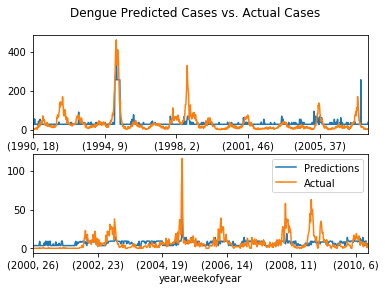

In [15]:
sj_best_model = random_forest_model(sj_train_subtrain, sj_train_subtest)
iq_best_model = random_forest_model(iq_train_subtrain, iq_train_subtest)

pred_sj = pd.Series(sj_best_model.predict(sj_train.drop(columns=["total_cases", 'week_start_date'])))
pred_iq = pd.Series(iq_best_model.predict(iq_train.drop(columns=["total_cases", 'week_start_date'])))

plot_against(pred_sj, pred_iq)

sj_mae = mae_calc(pred_sj.values, sj_train.total_cases)
sj_models_mae.append(sj_mae)
print("San Juan MAE:", sj_mae)
iq_mae = mae_calc(pred_iq.values, iq_train.total_cases)
iq_models_mae.append(iq_mae)
print("Iquitos MAE:", iq_mae)
total_mae = (np.abs(pred_sj.values - sj_train.total_cases).sum() + 
             np.abs(pred_iq.values - iq_train.total_cases).sum()) / (sj_train.shape[0] + iq_train.shape[0])
print("Total MAE:", total_mae)

Best score: 32.586200000000005
Best params: {'n_neighbors': 25}
Best score: 6.5228
Best params: {'n_neighbors': 25}
San Juan MAE: 28.443547008547007
Iquitos MAE: 6.551615384615385
Total MAE: 20.625


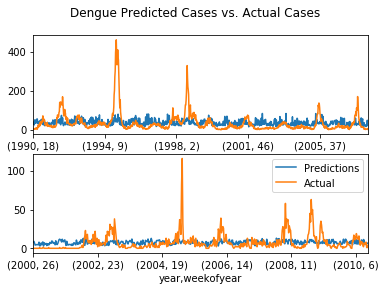

In [16]:
sj_best_model = kneighbours_model(sj_train_subtrain, sj_train_subtest)
iq_best_model = kneighbours_model(iq_train_subtrain, iq_train_subtest)

pred_sj = pd.Series(sj_best_model.predict(sj_train.drop(columns=["total_cases",'week_start_date'])))
pred_iq = pd.Series(iq_best_model.predict(iq_train.drop(columns=["total_cases",'week_start_date'])))

plot_against(pred_sj, pred_iq)

sj_mae = mae_calc(pred_sj.values, sj_train.total_cases)
sj_models_mae.append(sj_mae)
print("San Juan MAE:", sj_mae)
iq_mae = mae_calc(pred_iq.values, iq_train.total_cases)
iq_models_mae.append(iq_mae)
print("Iquitos MAE:", iq_mae)
total_mae = (np.abs(pred_sj.values - sj_train.total_cases).sum() + 
             np.abs(pred_iq.values - iq_train.total_cases).sum()) / (sj_train.shape[0] + iq_train.shape[0])
print("Total MAE:", total_mae)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


San Juan MAE: 17.800213675213676
Iquitos MAE: 8.448076923076924
Total MAE: 14.460164835164836


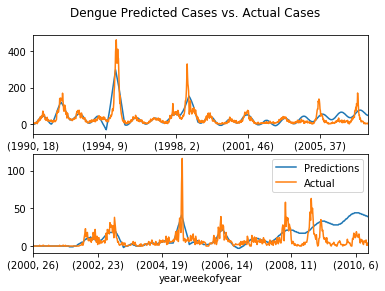

In [17]:
sj_best_model, test_prop_sj = fb_prophet_model(sj_train_subtrain, sj_train_subtest, 1, 52)
iq_best_model, test_prop_iq = fb_prophet_model(iq_train_subtrain, iq_train_subtest, 1, 10)

pred_sj = sj_best_model.predict(test_prop_sj)
pred_iq = iq_best_model.predict(test_prop_iq)

pred_sj = pred_sj[['ds', 'yhat']].yhat.apply(lambda x : int(x))
pred_iq = pred_iq[['ds', 'yhat']].yhat.apply(lambda x : int(x))

plot_against(pred_sj, pred_iq)

sj_mae = mae_calc(pred_sj.values, sj_train.total_cases)
sj_models_mae.append(sj_mae)
print("San Juan MAE:", sj_mae)
iq_mae = mae_calc(pred_iq.values, iq_train.total_cases)
iq_models_mae.append(iq_mae)
print("Iquitos MAE:", iq_mae)
total_mae = (np.abs(pred_sj.values - sj_train.total_cases).sum() + 
             np.abs(pred_iq.values - iq_train.total_cases).sum()) / (sj_train.shape[0] + iq_train.shape[0])
print("Total MAE:", total_mae)

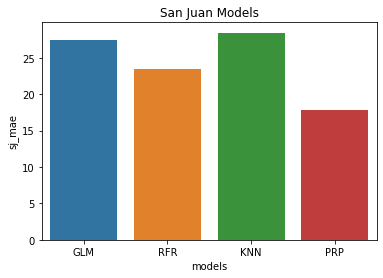

Text(0.5, 1.0, 'Iquitos Models')

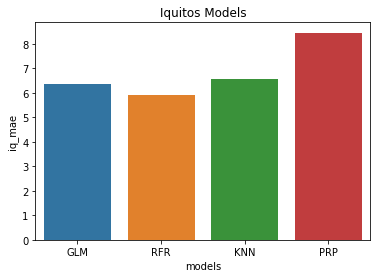

In [18]:
error_map = pd.DataFrame()
error_map["models"] = models
error_map["sj_mae"] = sj_models_mae
error_map["iq_mae"] = iq_models_mae
sns.barplot(x=error_map.models, y=error_map.sj_mae).set_title('San Juan Models')
plt.show()
sns.barplot(x=error_map.models, y=error_map.iq_mae).set_title('Iquitos Models')

## Predict on test set
Predicts on the test set given and saves predictions to benchmark.csv using the submission format given.

In [19]:
sj_best_model = random_forest_model(sj_train_subtrain, sj_train_subtest)
iq_best_model = iq_glm_model(iq_train_subtrain, iq_train_subtest)

Best score: 29.99013687160937
Best params: {'max_depth': 2, 'n_estimators': 12}
best alpha =  1e-08
best score =  7.083333333333333


In [20]:
test_features = pd.read_csv('./data/dengue_features_test.csv', index_col=[0,1,2])
sj_test, iq_test = preprocess_data(test_features)

sj_predictions = sj_best_model.predict(sj_test).astype(int)
iq_predictions = iq_best_model.predict(iq_test).astype(int)
save_benchmark(sj_predictions, iq_predictions)